# Predicting produce ripeness with hyperspectral image data 

## <a id='toc1_1_'></a>[Download and organize data](#toc0_)


In [1]:
import os
import zipfile
import urllib.request

# Create the data directory if it doesn't exist
os.makedirs('data', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)
os.makedirs('data/output', exist_ok=True)
os.makedirs('data/raw', exist_ok=True)

# URLs of the files to download
urls = [
    "https://cogsys.cs.uni-tuebingen.de/webprojects/DeepHS-Fruit-2023-Datasets/Kiwi.zip",
    "https://cogsys.cs.uni-tuebingen.de/webprojects/DeepHS-Fruit-2023-Datasets/annotations.zip",
    "https://cogsys.cs.uni-tuebingen.de/webprojects/DeepHS-Fruit-2023-Datasets/annotations-upd-2024-01-09.zip"
]

# Corresponding folder names to check
folders = [
    'data/raw/Kiwi',
    'data/raw/annotations'
]

# Download and unzip each file if the corresponding folder doesn't exist
for url, folder in zip(urls, folders):
    if not os.path.exists(folder):
        # Extract the filename from the URL
        filename = os.path.join('data/raw', os.path.basename(url))
        
        # Download the file
        urllib.request.urlretrieve(url, filename)
        
        # Unzip the file
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('data/raw')
        
        # Remove the zip file after extraction
        os.remove(filename)

## <a id='toc1_2_'></a>[Imports](#toc0_)

In [6]:
import json
import math
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
import loader_deepfruit as loader
import model_benchmark_deepfruits as model_benchmark
from configurations import *
from sklearn.model_selection import train_test_split

In [7]:
import importlib

# Reload local modules in case they have been changed
importlib.reload(model_benchmark)
importlib.reload(loader)
from configurations import *


## <a id='toc1_3_'></a>[Set produce and camera](#toc0_)

In [4]:
# Select a fruit to work with (Options: 'Kiwi'; Forthcoming: 'Avocado', 'Persimmons', 'Papayas', 'Mango')
fruit = 'Kiwi'
# Select a camera to work with (Options: 'VIS', 'NIR')
# VIS = Specim FX10
# NIR = INNOSPEC RedEye
camera = 'VIS'


In [5]:
if camera == 'VIS':
    wavelengths = 223
else:
    wavelengths = 251 

## <a id='toc1_4_'></a>[Prepare DataFrame](#toc0_)

In [6]:
# Function to load and join JSON file
def load_json(json_file):
    data = json.load(open(json_file))
    records = data.get('records', [])
    df_records = pd.json_normalize(records)
    annotations = data.get('annotations', [])
    df_annotations = pd.DataFrame(annotations)
    df_merged = pd.merge(df_records, df_annotations, left_on='id', right_on='record_id', how='right')
    return df_merged

# Load and normalize each JSON file
train_df = load_json('data/raw/annotations/train_only_labeled.json')
test_df = load_json('data/raw/annotations/test.json')
val_df = load_json('data/raw/annotations/val.json')

# Concatenate the DataFrames
df_combined = pd.concat([train_df, test_df, val_df], ignore_index=True)

# Display the combined DataFrame
print(df_combined.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_x                 442 non-null    int64  
 1   fruit                442 non-null    object 
 2   side                 442 non-null    object 
 3   day                  442 non-null    object 
 4   camera_type          442 non-null    object 
 5   files.header_file    442 non-null    object 
 6   files.data_file      442 non-null    object 
 7   id_y                 442 non-null    int64  
 8   record_id            442 non-null    int64  
 9   init_weight          442 non-null    int64  
 10  end_weight           424 non-null    float64
 11  storage_days         442 non-null    int64  
 12  firmness             424 non-null    float64
 13  comment              76 non-null     object 
 14  ripeness_state       442 non-null    object 
 15  ripeness_state_fine  442 non-null    obj

## <a id='toc1_5_'></a>[Drop irrelevant columns and convert columns to int/float where appropriate](#toc0_)

In [7]:
df_merged = df_combined.drop(columns=['comment'])
df_merged = df_merged.drop(columns=['id_y'])

In [8]:

# Create a copy of the DataFrame with only entries where column fruit is variable fruit
df_fruit = df_merged[df_merged['fruit'] == fruit].copy()
df_fruit = df_fruit.drop(columns=['fruit'])
print(fruit + " DataFrame:")
print(df_fruit.info())

Kiwi DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 262 entries, 8 to 441
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_x                 262 non-null    int64  
 1   side                 262 non-null    object 
 2   day                  262 non-null    object 
 3   camera_type          262 non-null    object 
 4   files.header_file    262 non-null    object 
 5   files.data_file      262 non-null    object 
 6   record_id            262 non-null    int64  
 7   init_weight          262 non-null    int64  
 8   end_weight           248 non-null    float64
 9   storage_days         262 non-null    int64  
 10  firmness             248 non-null    float64
 11  ripeness_state       262 non-null    object 
 12  ripeness_state_fine  262 non-null    object 
dtypes: float64(2), int64(4), object(7)
memory usage: 28.7+ KB
None


In [9]:
df = df_fruit.copy()

# 1. Define mappings for 'ripeness_state' and 'ripeness_state_fine'
ripeness_mapping = {"unripe":1, "perfect": 2, "overripe": 3}
ripeness_fine_mapping = {"unripe":1, "ripe":2,"perfect": 3, "near_overripe":4,"overripe": 5}

# 2. Apply the mappings to the DataFrame
df['ripeness_state'] = df['ripeness_state'].map(ripeness_mapping)
df['ripeness_state_fine'] = df['ripeness_state_fine'].map(ripeness_fine_mapping)

# 3. Apply day String to int transformation with error handling
df['day_int'] = pd.to_numeric(df['day'].str.extract(r'day_(\d+)')[0], errors='coerce').fillna(0).astype(int)
df = df.drop(columns=['day'])

## <a id='toc1_6_'></a>[Handle Missing values](#toc0_)

In [10]:
# Check for missing values
print(df.isnull().sum())

id_x                    0
side                    0
camera_type             0
files.header_file       0
files.data_file         0
record_id               0
init_weight             0
end_weight             14
storage_days            0
firmness               14
ripeness_state          0
ripeness_state_fine     0
day_int                 0
dtype: int64


In [11]:
target_columns = ['end_weight', 'firmness']
# 1. Identify missing values in the original DataFrame
missing_mask = df[target_columns ].isnull()
print("Rows with missing values before imputation:")
print(df[missing_mask.any(axis=1)][target_columns])

Rows with missing values before imputation:
     end_weight  firmness
210         NaN       NaN
211         NaN       NaN
224         NaN       NaN
225         NaN       NaN
238         NaN       NaN
239         NaN       NaN
317         NaN       NaN
318         NaN       NaN
321         NaN       NaN
323         NaN       NaN
382         NaN       NaN
419         NaN       NaN
420         NaN       NaN
438         NaN       NaN


In [12]:
df_copy = df.copy()

# Define relevant feature columns and target columns
scaler = StandardScaler()
impute_features = ['init_weight', 'ripeness_state', 'ripeness_state_fine', 'storage_days']

df_copy[impute_features] = scaler.fit_transform(df_copy[impute_features])

# Initialize the KNN Imputer
imputer = KNNImputer(n_neighbors=10)

# Fit the imputer on the relevant features and target columns
# Combine impute_features and target_columns for imputation
impute_df = df_copy[impute_features + target_columns]

# Apply the imputer
imputed_array = imputer.fit_transform(impute_df)

# Convert the imputed array back to a DataFrame
imputed_df = pd.DataFrame(imputed_array, columns=impute_features + target_columns, index=df.index)

# Update only the target columns in the original DataFrame
df[target_columns] = imputed_df[target_columns]

# Print the imputed values using the same mask
print("Imputed values:")
print(df[missing_mask.any(axis=1)][target_columns])

# Verify that there are no missing values in 'end_weight' and 'firmness'
print("Missing values after imputation:")
print(df[target_columns].isnull().sum())


Imputed values:
     end_weight  firmness
210       111.4     280.0
211       111.4     280.0
224       111.4     280.0
225       111.4     280.0
238       111.4     280.0
239       111.4     280.0
317       105.0     795.0
318       105.0     795.0
321       105.0     795.0
323       105.0     795.0
382       105.0     795.0
419       111.4     280.0
420       111.4     280.0
438       105.0     795.0
Missing values after imputation:
end_weight    0
firmness      0
dtype: int64


## <a id='toc1_7_'></a>[Label refinement](#toc0_)

In [13]:
# Create the 'weightloss %' column
df['weightloss %'] = df['init_weight'] - df['end_weight']
df['weightloss %'] = df['weightloss %']  / df['init_weight']
# Verify the new columns
df.describe().loc[['mean','min','max']].T

,mean,min,max
id_x,132.973282,2.000000,327.000000
record_id,132.973282,2.000000,327.000000
init_weight,119.717557,88.000000,135.000000
end_weight,117.019847,87.000000,133.000000
storage_days,5.572519,0.000000,18.000000
firmness,1331.908397,0.000000,3200.000000
ripeness_state,1.969466,1.000000,3.000000
ripeness_state_fine,2.595420,1.000000,5.000000
day_int,2.732824,0.000000,10.000000
weightloss %,0.022786,-0.003604,0.079646


In [14]:
# 1. Make a copy of the DataFrame
df_copy = df.copy()

# 2. Regularize 
scaler = StandardScaler()
features = ['firmness', 'ripeness_state', 'weightloss %', 'init_weight', 'end_weight', 'ripeness_state_fine']
df_copy[features] = scaler.fit_transform(df_copy[features])

def train_and_refine(df, features, target):
    """
    Train an SVR model and predict the target variable.

    Parameters:
    - df: The DataFrame containing the data.
    - features: A list of feature column names.
    - target: The target column name.

    Returns:
    - df: The DataFrame with SVR predictions and differences added.
    """

    # 3. Define features and target variable
    X = df_copy[features]
    y = df[target]

    # 4. Train an SVR model
    svr = SVR(kernel='rbf')
    svr.fit(X, y)

    # 5. Predict the target variable using the trained SVR model
    df_copy[target+'_synthetic'] = svr.predict(X)

    # 6. Add the SVR predictions to the original DataFrame
    df[target+'_synthetic'] = df_copy[target+'_synthetic']

    # Verify the new columns
    print(f"Summary statistics of '{target}_synthetic':")
    print(df[target+'_synthetic'].describe())

    return df
features = ['firmness', 'weightloss %', 'init_weight', 'end_weight', 'ripeness_state_fine']
df = train_and_refine(df, features, 'ripeness_state')
features = ['ripeness_state', 'weightloss %', 'init_weight', 'end_weight']
df = train_and_refine(df, features, 'ripeness_state_fine')


Summary statistics of 'ripeness_state_synthetic':
count    262.000000
mean       1.967680
std        0.697174
min        0.963421
25%        1.109456
50%        1.905635
75%        2.510081
max        3.100335
Name: ripeness_state_synthetic, dtype: float64


Summary statistics of 'ripeness_state_fine_synthetic':
count    262.000000
mean       2.631652
std        1.443526
min        0.899537
25%        1.099951
50%        2.397380
75%        4.099817
max        4.952275
Name: ripeness_state_fine_synthetic, dtype: float64


In [15]:
def standardize_column(df, column_name, new_min=1, new_max=3):
    """
    Standardize the values in a column to a new range [new_min, new_max].

    Parameters:
    - df: The DataFrame containing the data.
    - column_name: The name of the column to standardize.
    - new_min: The minimum value of the new range.
    - new_max: The maximum value of the new range.

    Returns:
    - df: The DataFrame with the standardized column.
    """
    old_min = df[column_name].min()
    old_max = df[column_name].max()
    df[column_name] = ((df[column_name] - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
    return df

columns_to_standardize = [
    'ripeness_state',
    'ripeness_state_fine',
    'ripeness_state_synthetic',
    'ripeness_state_fine_synthetic',
]

for column in columns_to_standardize:
    df = standardize_column(df, column)

# Verify the standardized columns
df.describe().loc[['mean', 'min', 'max'], columns_to_standardize].T

,mean,min,max
ripeness_state,1.969466,1.0,3.0
ripeness_state_fine,1.797710,1.0,3.0
ripeness_state_synthetic,1.939915,1.0,3.0
ripeness_state_fine_synthetic,1.854787,1.0,3.0


In [16]:
# 2. Check correlation between two columns, e.g., 'firmness' and 'ripeness_state_fine'

correlation = df['ripeness_state'].corr(df['ripeness_state_fine'])

# Print the correlation results

print(f"Correlation between 'firmness' and 'ripeness_state_fine' for Kiwi: {correlation}")

Correlation between 'firmness' and 'ripeness_state_fine' for Kiwi: 0.9479973117954898


## <a id='toc1_8_'></a>[Save csvs for each camera setup](#toc0_)

In [17]:
# Create a copy of the DataFrame with only entries where camera_type is 'NIR'
df_NIR = df[df['camera_type'] == 'NIR'].copy()

# Create a copy of the DataFrame with only entries where camera_type is 'VIS'
df_VIS = df[df['camera_type'] == 'VIS'].copy()

# Save the DataFrames to the 'data/processed' directory
df_VIS.to_csv(os.path.join('data/processed', fruit + '_table_VIS.csv'), index=False)
df_NIR.to_csv(os.path.join('data/processed', fruit + '_table_NIR.csv'), index=False)

In [18]:
# Verify the independent DataFrames
print(df_NIR.info())
print(df_VIS.info())

<class 'pandas.core.frame.DataFrame'>
Index: 76 entries, 8 to 414
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id_x                           76 non-null     int64  
 1   side                           76 non-null     object 
 2   camera_type                    76 non-null     object 
 3   files.header_file              76 non-null     object 
 4   files.data_file                76 non-null     object 
 5   record_id                      76 non-null     int64  
 6   init_weight                    76 non-null     int64  
 7   end_weight                     76 non-null     float64
 8   storage_days                   76 non-null     int64  
 9   firmness                       76 non-null     float64
 10  ripeness_state                 76 non-null     float64
 11  ripeness_state_fine            76 non-null     float64
 12  day_int                        76 non-null     int64  
 

## <a id='toc1_9_'></a>[Verify label distributions before analysis](#toc0_)

Label distribution for 'ripeness_state':
ripeness_state
1.0    0.311828
2.0    0.430108
3.0    0.258065
Name: proportion, dtype: float64


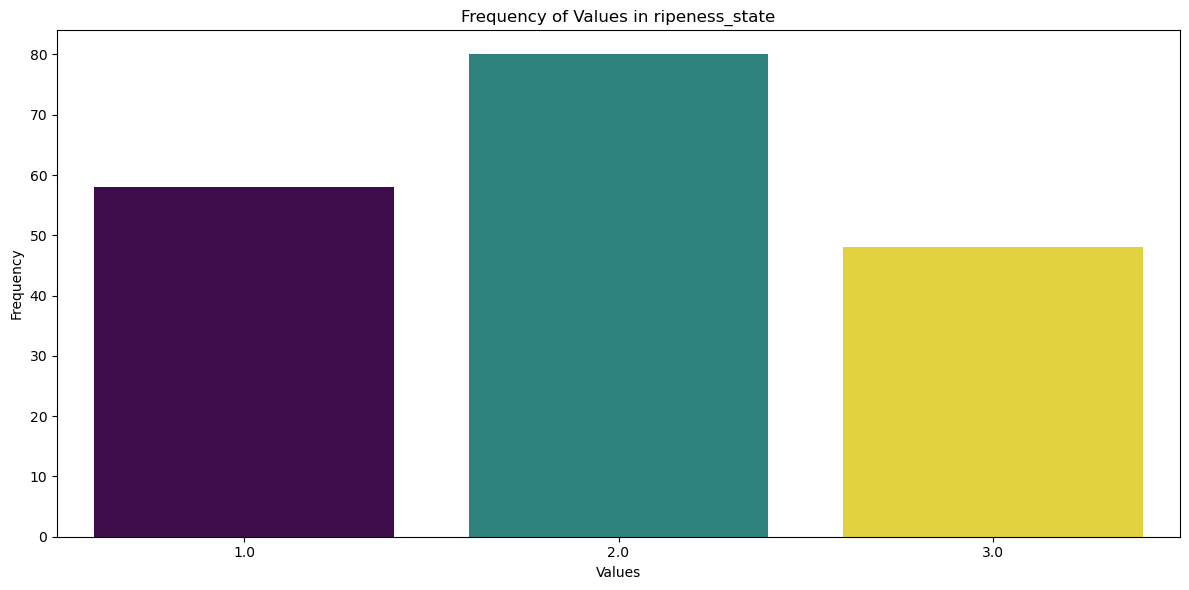

Label distribution for 'ripeness_state_fine':
ripeness_state_fine
1.0    0.311828
1.5    0.301075
2.0    0.129032
2.5    0.053763
3.0    0.204301
Name: proportion, dtype: float64


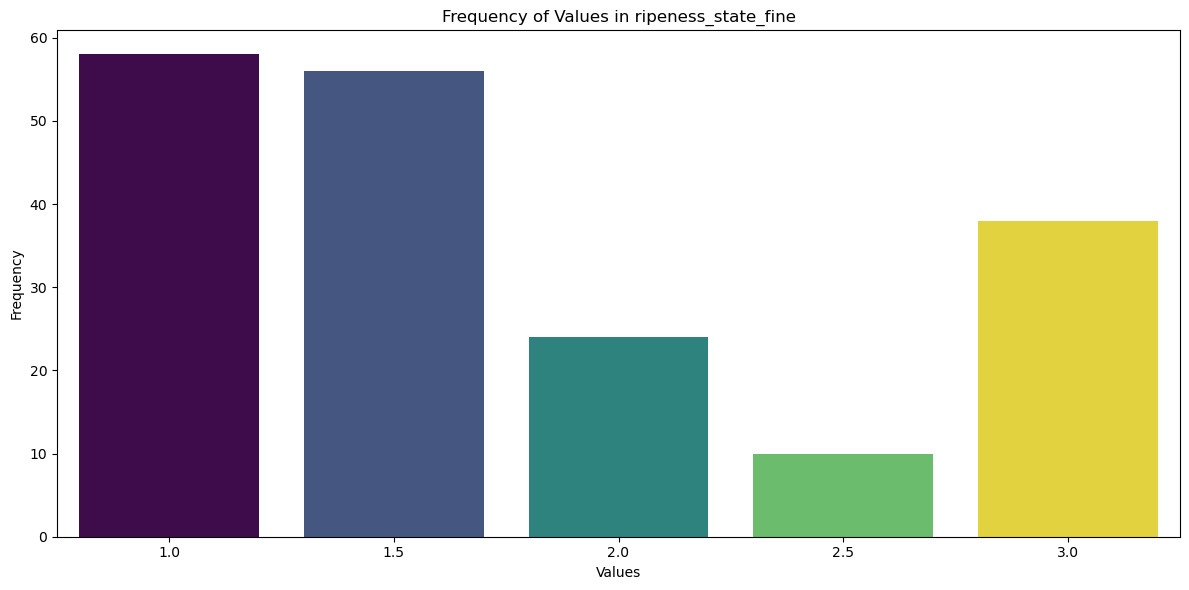

Label distribution for 'ripeness_state':
ripeness_state
1.0    0.236842
2.0    0.500000
3.0    0.263158
Name: proportion, dtype: float64


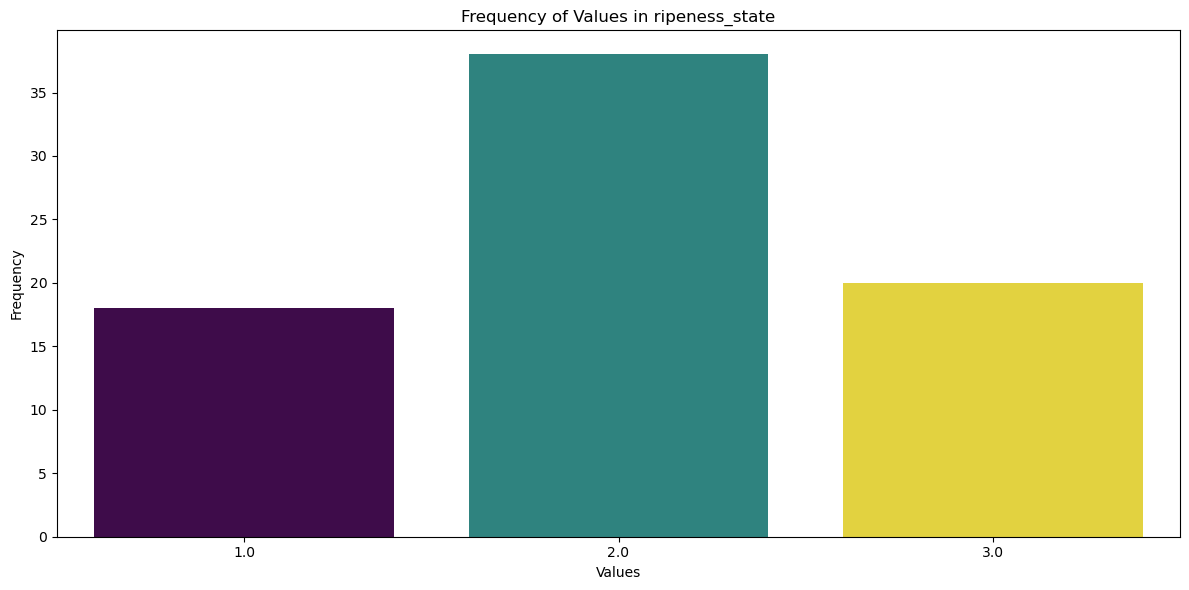

Label distribution for 'ripeness_state_fine':
ripeness_state_fine
1.0    0.236842
1.5    0.236842
2.0    0.263158
2.5    0.078947
3.0    0.184211
Name: proportion, dtype: float64


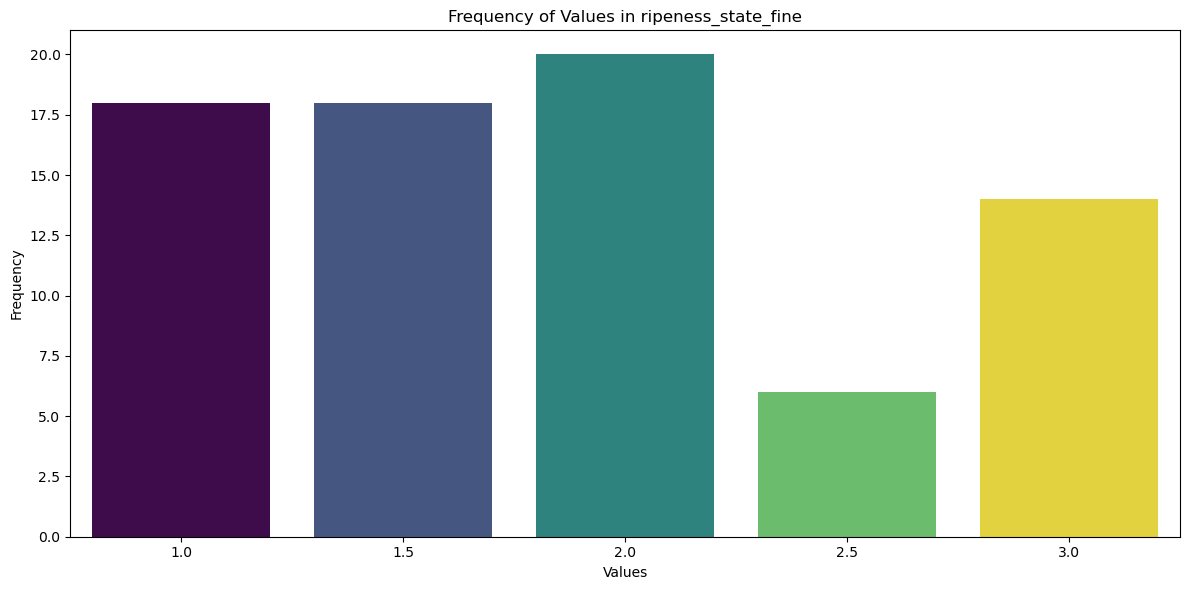

In [19]:
def check_label_distrbution(df, column_name):
    """
    Check the distribution of labels in the specified column of the DataFrame.
    
    Parameters:
    - df: A pandas DataFrame containing the data.
    - column_name: The name of the column to check for label distribution.
    """
    # Calculate the frequency of each label
    label_freq = df[column_name].value_counts(normalize=True).sort_index()
    
    # Display the frequency of each label
    print(f"Label distribution for '{column_name}':")
    print(label_freq)
    
    # Plot the frequency of each label
    plt.figure(figsize=(12, 6))
    sns.countplot(x=column_name, data=df, hue=column_name, palette='viridis', legend=False)
    plt.title(f'Frequency of Values in {column_name}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
check_label_distrbution(df_VIS, 'ripeness_state')
check_label_distrbution(df_VIS, 'ripeness_state_fine')
check_label_distrbution(df_NIR, 'ripeness_state')
check_label_distrbution(df_NIR, 'ripeness_state_fine')

## <a id='toc1_10_'></a>[Loading, Preprocessing and Saving the Images](#toc0_)

In [20]:
 
csv_file='data/processed/'+fruit+'_table_'+camera+'.csv'
print(f"Loading images from {csv_file}...")
# Load the CSV file
df = pd.read_csv(csv_file)

image_count=162
stat_use=1
x_axis=4
y_axis=100
wavelengths
wavelength_factor=2
target_statistic='MAE'

"""
----------
json_file : 
   Path to the JSON file containing labels and paths to images.
image_count :
   Max Number of images to load per label.
target_label :
   Target label to load.
stat_use : 
   Flag to determine if statistics should be used or the raw image.
x_axis : 
   Size along the x-axis for image slicing.
y_axis :
   Size along the y-axis for image slicing.
wavelengths :
   Total number of wavelengths for the data set.
wavelength_factor : 
   Factor by which wavelengths are averaged.
"""

data, length_of_statistics, pca, scaler = loader.load_spectral_data(df,
                                                     image_count,
                                                     stat_use,
                                                     x_axis,
                                                     y_axis,
                                                     wavelengths,
                                                     wavelength_factor)

wave_count=int(math.ceil(wavelengths/wavelength_factor))


Loading images from data/processed/Kiwi_table_VIS.csv...
Parameters used: image_count=162, stat_use=1, x_axis=4, y_axis=100, wavelengths=223, wavelength_factor=2
Loaded 186 images.
Applied 31 stats.
Dimensions of all_stats: (186, 3472). This represents the statistics of the spectral data.

Explained variance ratio: [5.20952599e-01 1.28221826e-01 1.09685676e-01 7.34384950e-02
 3.50699863e-02 3.12910602e-02 2.50255362e-02 1.09663491e-02
 8.81046789e-03 7.94215439e-03 6.08262879e-03 4.61192104e-03
 4.50384457e-03 3.86306647e-03 1.98370669e-03 1.93980931e-03
 1.81725393e-03 1.57720680e-03 1.23494005e-03 1.12370837e-03
 1.07735672e-03 9.79412312e-04 8.84357767e-04 7.79788073e-04
 7.06701504e-04 6.63349071e-04 6.29912690e-04 5.83863049e-04
 5.45638137e-04 4.85915254e-04 4.55880835e-04 4.31152603e-04
 3.87422709e-04 3.57187578e-04 3.30638782e-04 3.12622558e-04
 3.10701883e-04 3.06273559e-04 2.94058344e-04 2.65822131e-04
 2.61365575e-04 2.53397352e-04 2.47777930e-04 2.33950398e-04
 2.29164054e

In [ ]:
# Method to save variables to a file
def save_variables(filename, data, length_of_statistics):
    with open(filename, 'wb') as f:
        pickle.dump((data, length_of_statistics), f)

# Save variables to a file in the 'data/processed' directory
save_variables('data/processed/'+fruit+'_'+camera+'_'+'images.pkl', data, length_of_statistics)

## <a id='toc1_11_'></a>[Model fitting](#toc0_)



In [21]:
# Select a fruit to work with (Options: 'Kiwi'; Forthcoming: 'Avocado', 'Persimmons', 'Papayas', 'Mango')
fruit = 'Kiwi'
# Select a camera to work with (Options: 'VIS', 'NIR')
# VIS = Specim FX10
# NIR = INNOSPEC RedEye
camera = 'VIS'


In [22]:
if camera == 'VIS':
    wavelengths = 223
else:
    wavelengths = 251 

In [23]:
csv_file='data/processed/'+fruit+'_table_'+camera+'.csv'
print(f"Loading images from {csv_file}...")
# Load the CSV file
df = pd.read_csv(csv_file)

# Method to load variables from a file
def load_variables(filename):
    with open(filename, 'rb') as f:
        data, length_of_statistics = pickle.load(f)
    return data, length_of_statistics

# Load images from a file
data, length_of_statistics = load_variables('data/processed/'+fruit+'_'+camera+'_'+'images.pkl')


Loading images from data/processed/Kiwi_table_VIS.csv...


In [24]:
#Set target and refrence label
target_label = df['ripeness_state_synthetic']
refrence_label = df['ripeness_state']
stratfication_label=df['ripeness_state_fine']
# Potential labels
# init_weight
# end_weight                
# storage_days                
# firmness                       
# ripeness_state                
# ripeness_state_fine            
# day_int                      
# weightloss %                  
# ripeness_state_synthetic      
# ripeness_state_fine_synthetic  

target_statistics = [
   {'target_statistic':'MAE','position_target_statistic':1},
   {'target_statistic':'MSE','position_target_statistic':2},
   {'target_statistic':'RS','position_target_statistic':3}
]



In [25]:
# Verify the loaded variables
print(f"Data shape: {data.shape}")
print(f"Target Labels shape: {target_label.shape}")
print(f"Length of statistics: {length_of_statistics}")
print(f"Refrence Labels shape: {refrence_label.shape}")

Data shape: (186, 120)
Target Labels shape: (186,)
Length of statistics: 31
Refrence Labels shape: (186,)


In [26]:
# Split the data and labels
train_data, test_data, train_labels, test_labels, train_refrence, test_refrence = train_test_split(
    data, target_label, refrence_label, test_size=0.2, random_state=42, stratify=stratfication_label
)

In [27]:
model_benchmark.process_spectral_data(train_data, train_labels,test_data, test_labels, configurations_dummy)


Average Mean Absolute Error: 2.7782
Average Mean Squared Error : 12.2808
Average R^2 score          : -26.8176
Configuration: {'model_type': 'kmeans', 'n_clusters': 10, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300}
Average Training Time      : 0.0741
Average Testing Time       : 0.0016

Average Mean Absolute Error: 1.3808
Average Mean Squared Error : 3.3932
Average R^2 score          : -6.686
Configuration: {'model_type': 'linear_regression', 'fit_intercept': True}
Average Training Time      : 0.002
Average Testing Time       : 0.0001

Average Mean Absolute Error: 0.6763
Average Mean Squared Error : 0.8901
Average R^2 score          : -1.0162
Configuration: {'model_type': 'ridge', 'alpha': 4}
Average Training Time      : 0.0015
Average Testing Time       : 0.0002

Average Mean Absolute Error: 0.5317
Average Mean Squared Error : 0.4415
Average R^2 score          : -0.0001
Configuration: {'model_type': 'dummy_mean', 'strategy': 'mean'}
Average Training Time      : 0.0005
Average T

In [40]:
features_to_eliminate = model_benchmark.feature_optimizer(train_data, train_labels, test_data, test_labels, configurations_dummy)

Features to be eliminated: [4, 8, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 24, 25, 30, 31, 35, 39, 41, 45, 46, 47, 48, 49, 52, 55, 57, 58, 61, 62, 63, 64, 67, 68, 71, 72, 73, 74, 75, 77, 81, 82, 83, 84, 86, 88, 89, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 109, 111, 113, 114, 115, 117, 118]

Average Mean Absolute Error: 3.5728
Average Mean Squared Error : 19.1913
Average R^2 score          : -42.471
Configuration: {'model_type': 'kmeans', 'n_clusters': 10, 'init': 'k-means++', 'n_init': 10, 'max_iter': 300}
Average Training Time      : 0.0676
Average Testing Time       : 0.0048

Average Mean Absolute Error: 0.5317
Average Mean Squared Error : 0.4415
Average R^2 score          : -0.0001
Configuration: {'model_type': 'dummy_mean', 'strategy': 'mean'}
Average Training Time      : 0.0004
Average Testing Time       : 0.0

Average Mean Absolute Error: 0.5306
Average Mean Squared Error : 0.7137
Average R^2 score          : -0.6167
Configuration: {'model_type': 'svr', 'kernel': 

In [44]:
import importlib

# Reload local modules in case they have been changed
importlib.reload(model_benchmark)
importlib.reload(loader)
from configurations import *


{'model_type': 'svr', 'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
defaultdict(<class 'list'>, {(0.34786750696918906, 0.19084207816550414, 0.5677168971593303): [({'model_type': 'svr', 'kernel': 'rbf', 'C': 10, 'gamma': 0.001}, {'Average Training Time': 0.0049076080322265625, 'Average Testing Time': 0.0006909370422363281})]})
Predicted labels: [2.27030078 3.09359106 2.55302764 1.65109202 1.49464464 1.92510595
 2.76088886 1.11407091 2.12699908 2.0771037  1.18785991 1.66799918
 1.15386906 2.26427589 2.39976073 2.24699846 1.69429789 1.96465525
 1.8336854  1.35850945 2.33221545 2.30021155 2.82069439 2.89463807
 2.55351332 1.35630599 1.2264687  1.05046236 1.59732311 2.30314279
 2.57403474 1.80257166 1.8363869  2.08193921 2.05118645 2.85529107
 0.84811517 1.81785437]


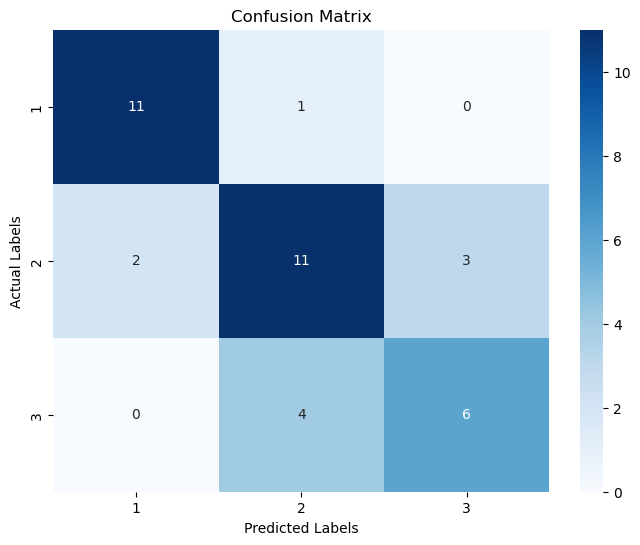

Predicted labels: [2 3 3 1 1 2 3 1 2 2 1 1 1 2 3 2 1 2 2 1 2 2 3 3 3 1 1 1 1 2 3 2 2 2 2 3 1
 2]
Actual ripeness : [2. 3. 3. 2. 1. 2. 2. 1. 2. 1. 1. 1. 2. 2. 3. 2. 1. 2. 2. 1. 3. 3. 3. 3.
 2. 1. 1. 1. 1. 2. 2. 3. 3. 2. 2. 3. 1. 2.]
Accuracy: 0.7368421052631579
174    1.876414
57     1.127614
161    1.876134
184    2.026535
33     1.113295
         ...   
72     1.876648
133    2.983014
28     2.035680
114    1.133379
125    2.812375
Name: ripeness_state_synthetic, Length: 148, dtype: float64


In [45]:
config ={'model_type': 'svr', 'kernel': 'rbf', 'C': 10, 'gamma': 0.001}
train_data = model_benchmark.remove_features(train_data, features_to_eliminate[0], features_to_eliminate[1:])
test_data = model_benchmark.remove_features(test_data, features_to_eliminate[0], features_to_eliminate[1:])


model_benchmark.compare_accuracy(config, train_data, train_labels, test_data, test_labels, test_refrence)
print(train_labels)
